# I. First step : Simple Convolutionnal Neural Network (CNN)

## On MNIST

### Import the library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

### Collecting the data

In [2]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform
)

In [3]:
print("shape of train data : " , train_data.data.size())
print("shape of test data : " , test_data.data.size())
print("shape of train labels : " , train_data.targets.size())

shape of train data :  torch.Size([60000, 28, 28])
shape of test data :  torch.Size([10000, 28, 28])
shape of train labels :  torch.Size([60000])


### Preprocessing

In [4]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),

    'test'  : DataLoader(test_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x105c31af0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x147cf4e20>}

tensor(5)


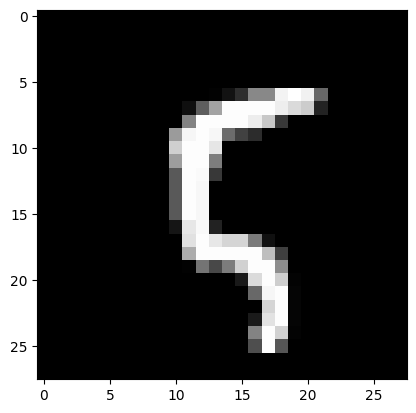

In [5]:
plt.imshow(train_data.data[100],cmap='gray')
print(train_data.targets[100])

### Building the network

In [6]:
import torch.nn as nn
from torch.nn import Sequential,Conv2d,AvgPool2d,Flatten,Linear,Sigmoid

In [7]:
nb_epoch = 20

#Define the model Sequential

model = Sequential(
    Conv2d(in_channels = 1,out_channels = 6,kernel_size = (5,5),padding = 2),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5)),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Flatten(),
    Linear(16*5*5,120),
    Sigmoid(),
    Linear(120,84),
    Sigmoid(),
    Linear(84,10)
)

In [8]:
from torchvision import models
from torchsummary import summary
print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [10]:
import torch.optim as optim

#Define Loss function and Optimizer :
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
num_epochs = 20

#Train the model:

def train(num_epochs, cnn, loaders):
    loss_value = np.zeros((20,2))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(loaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            print(outputs.size())
            print(labels.size())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        loss_value[epoch] = [epoch,loss.item()]
    print('Finished Training')
    return loss_value
loss_value  = train(nb_epoch,model, loaders)

tensor([[ 0.4243,  0.4952,  0.3916,  ..., -0.5406, -0.0534,  0.2808],
        [ 0.4243,  0.4950,  0.3916,  ..., -0.5405, -0.0536,  0.2806],
        [ 0.4242,  0.4951,  0.3918,  ..., -0.5405, -0.0536,  0.2807],
        ...,
        [ 0.4241,  0.4951,  0.3916,  ..., -0.5407, -0.0533,  0.2807],
        [ 0.4242,  0.4951,  0.3916,  ..., -0.5406, -0.0535,  0.2807],
        [ 0.4243,  0.4951,  0.3915,  ..., -0.5406, -0.0534,  0.2807]],
       grad_fn=<AddmmBackward0>)
tensor([4, 5, 7, 7, 2, 7, 7, 4, 6, 9, 5, 0, 6, 9, 5, 4, 2, 5, 1, 6, 6, 9, 4, 6,
        7, 7, 3, 1, 7, 3, 7, 2, 4, 1, 8, 2, 0, 7, 5, 4, 1, 4, 0, 9, 0, 6, 7, 6,
        7, 5, 3, 3, 8, 5, 5, 6, 6, 1, 8, 4, 6, 7, 7, 4, 8, 7, 4, 1, 5, 4, 8, 1,
        8, 3, 5, 9, 6, 7, 8, 3, 0, 8, 3, 6, 4, 7, 1, 3, 7, 1, 1, 5, 4, 6, 4, 3,
        9, 8, 3, 8, 1, 1, 4, 2, 6, 5, 7, 5, 6, 8, 0, 4, 3, 8, 2, 1, 9, 1, 2, 1,
        2, 1, 8, 5, 3, 0, 2, 9])
torch.Size([128, 10])
torch.Size([128])
tensor([[ 0.3305,  0.4212,  0.3015,  ..., -0.4374, -0.0147, 

KeyboardInterrupt: 

In [12]:
#Test the model:

def test(cnn,loaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loaders['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            print(labels.size(0))
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
test(model,loaders)

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
16
Accuracy of the network on the 10000 test images: 97.42 %


In [13]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

NameError: name 'loss_value' is not defined

# II. Second step: Simple Convolutionnal Neural Network on more complex data.

### Load the data

In [34]:
from torch.utils.data import TensorDataset

xTrain=np.load('./pathmnist/train_images.npy')
xTest=np.load('./pathmnist/test_images.npy')
yTrain=np.load('./pathmnist/train_labels.npy')
yTest=np.load('./pathmnist/test_labels.npy')

xTrain = torch.Tensor(xTrain)# transform to torch tensor
yTrain = torch.LongTensor(yTrain)
xTest = torch.Tensor(xTest)
yTest = torch.LongTensor(yTest)

#Change the size (:,28,28,3) to (:,3,28,28)
xTrain = xTrain.permute(0, 3, 1, 2)
xTest = xTest.permute(0, 3, 1, 2)

train_dataset = TensorDataset(xTrain,yTrain) # create your datset
test_dataset = TensorDataset(xTest,yTest)

loaders = {
    'train' : DataLoader(train_dataset,
                         batch_size=64,
                         shuffle=100,
                         num_workers=1),

    'test'  : DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=100,
                         num_workers=1),
}
loaders
print(loaders['train'])

### Building the network

In [15]:
from torch import sigmoid,flatten

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels = 3,out_channels = 6,kernel_size = (5,5),padding = 2)
        self.pool = AvgPool2d(kernel_size = (2,2),stride = 2)
        self.conv2 = Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5))
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 9)

    def forward(self, x):
        x = self.pool(sigmoid(self.conv1(x)))
        x = self.pool(sigmoid(self.conv2(x)))
        x = flatten(x,1) # flatten all dimensions except batch
        x = sigmoid(self.fc1(x))
        x = sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

In [16]:
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)


In [17]:
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 9]             765
Total params: 61,921
Trainable params: 61,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [18]:
def train(num_epochs, cnn, loaders):
    loss_value = np.zeros((20,2))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(loaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels[:,0]) #To have label in good size
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        loss_value[epoch] = [epoch,loss.item()]
    print('Finished Training')
    return loss_value

loss_value  = train(nb_epoch,model,loaders)

[1,   100] loss: 2.304
[1,   200] loss: 2.294
[1,   300] loss: 2.308
[1,   400] loss: 2.304
[1,   500] loss: 2.305
[1,   600] loss: 2.300
[1,   700] loss: 2.291
[1,   800] loss: 2.310
[1,   900] loss: 2.298
[1,  1000] loss: 2.306
[1,  1100] loss: 2.294
[1,  1200] loss: 2.290
[1,  1300] loss: 2.291
[1,  1400] loss: 2.290
[2,   100] loss: 2.298
[2,   200] loss: 2.299
[2,   300] loss: 2.298
[2,   400] loss: 2.293
[2,   500] loss: 2.303
[2,   600] loss: 2.300
[2,   700] loss: 2.304
[2,   800] loss: 2.296
[2,   900] loss: 2.305
[2,  1000] loss: 2.292
[2,  1100] loss: 2.296
[2,  1200] loss: 2.303
[2,  1300] loss: 2.302
[2,  1400] loss: 2.295
[3,   100] loss: 2.300
[3,   200] loss: 2.299
[3,   300] loss: 2.297
[3,   400] loss: 2.299
[3,   500] loss: 2.298
[3,   600] loss: 2.296
[3,   700] loss: 2.301
[3,   800] loss: 2.304
[3,   900] loss: 2.294
[3,  1000] loss: 2.301
[3,  1100] loss: 2.293
[3,  1200] loss: 2.302
[3,  1300] loss: 2.304
[3,  1400] loss: 2.294
[4,   100] loss: 2.295
[4,   200] 

In [19]:
def test(cnn,loaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loaders['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            print(labels.size(0))
            print((predicted == labels).sum().item())
            correct += (predicted == labels).sum().item()
    print(correct)
    print(total)
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

test(model,loaders)

64
256
64
192
64
384
64
192
64
192
64
512
64
64
64
256
64
128
64
192
64
384
64
128
64
64
64
64
64
192
64
128
64
320
64
384
64
64
64
0
64
384
64
192
64
384
64
128
64
256
64
320
64
192
64
192
64
128
64
320
64
64
64
192
64
192
64
256
64
256
64
256
64
256
64
192
64
128
64
128
64
384
64
192
64
448
64
64
64
128
64
192
64
256
64
320
64
192
64
320
64
128
64
448
64
64
64
320
64
128
64
192
64
320
64
192
64
192
64
320
64
448
64
128
64
192
64
384
64
0
64
320
64
384
64
192
64
384
64
256
64
320
64
64
64
128
64
384
64
576
64
256
64
128
64
128
64
192
64
256
64
128
64
384
64
128
64
192
64
256
64
192
64
256
64
384
64
448
64
256
64
128
64
320
64
128
64
320
64
384
64
256
64
512
64
512
64
384
64
192
64
192
64
256
64
256
64
320
64
128
64
64
64
256
64
320
64
448
64
64
64
320
64
128
12
0
26944
7180
Accuracy of the network on the 10000 test images: 375.2646239554318 %


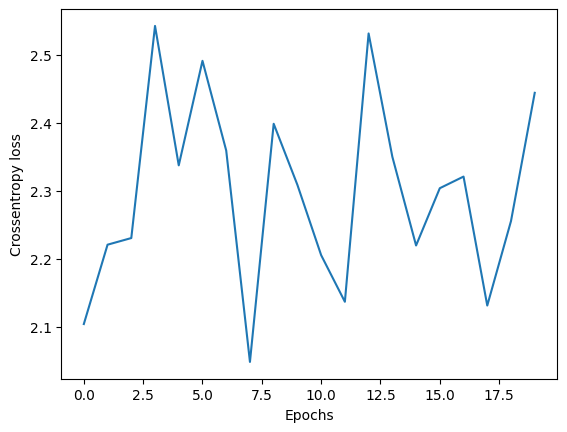

In [20]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

# Third step : Transfer learning

In [59]:
import glob
from tqdm import tqdm
from torchvision.models import vgg16
from PIL import Image
from torch.utils.data import Dataset
import os

In [60]:
classes = ['mucca', 'elefante', 'gatto', 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)
datasetRoot = 'animal-10/raw-img/'

rootTrain = datasetRoot+'train/'
classLabel = 0

# define a transform to resize the input images and convert them to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# initialize the input and output data
xTrain = torch.empty(size=(0, 3, 224, 224))
yTrain = []

for cl in classes:
    listImages = glob.glob(rootTrain + cl + '/*')[:100]
    yTrain += [classLabel] * len(listImages)

    for pathImg in listImages:
        img = Image.open(pathImg)  # load image
        im = transform(img)  # apply transform
        im = im.unsqueeze(0)  # add a batch dimension
        xTrain = torch.cat([xTrain, im])  # add the image to the train dataset

    classLabel += 1

print(len(yTrain))
print(xTrain.shape)

# convert the output labels to one-hot encoded vectors
yTrain = torch.nn.functional.one_hot(torch.tensor(yTrain), num_classes=nbClasses)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 3 but got size 4 for tensor number 1 in the list.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


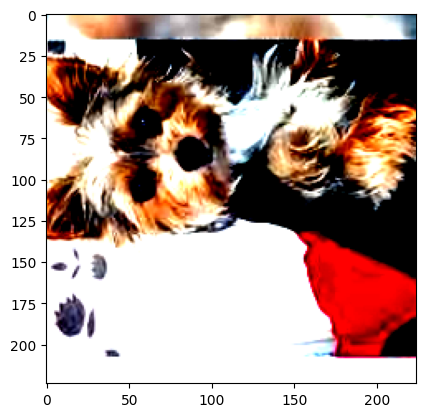

In [47]:
im,label = dataloader.dataset[0]
im = im.permute(2, 1, 0)
plt.imshow(im)
plt.show()